In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

DIR=r'C:\Users\Yhara\Desktop\hackathon'

In [389]:
df = pd.read_csv(os.path.join(DIR, 'handouts_fhs.csv'))

In [390]:
#lets look on the head of our dataframe
display(df.head(5))

,randid,death,angina,hospmi,mi_fchd,anychd,stroke,cvd,hyperten,timeap,...,heartrte3,glucose3,prevchd3,prevap3,prevmi3,prevstrk3,prevhyp3,hdlc3,ldlc3,bmidiff
0,2448,No,No,Yes,Yes,Yes,No,Yes,No,24.000000,...,69.0,92.0,No,No,No,No,No,31.0,178.0,NaN
1,6238,No,No,No,No,No,No,No,No,24.000000,...,80.0,71.0,No,No,No,No,No,54.0,141.0,-0.70
2,9428,No,No,No,No,No,No,No,No,24.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
3,10552,Yes,No,No,No,No,Yes,Yes,Yes,8.093087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.60
4,11252,No,No,No,No,No,No,No,Yes,24.000000,...,74.0,NaN,No,No,No,No,Yes,NaN,NaN,-0.38


In [391]:
#the bottom of the dataframe
display(df.tail())

,randid,death,angina,hospmi,mi_fchd,anychd,stroke,cvd,hyperten,timeap,...,heartrte3,glucose3,prevchd3,prevap3,prevmi3,prevstrk3,prevhyp3,hdlc3,ldlc3,bmidiff
4429,9990894,Yes,No,No,No,No,No,No,Yes,17.612594,...,80.0,91.0,No,No,No,No,Yes,47.0,181.0,0.36
4430,9993179,Yes,No,No,No,No,No,No,Yes,18.422998,...,95.0,90.0,No,No,No,No,Yes,70.0,181.0,-2.06
4431,9995546,No,Yes,No,Yes,Yes,No,Yes,Yes,16.260096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.08
4432,9998212,No,No,No,No,No,No,No,Yes,24.000000,...,65.0,72.0,No,No,No,No,Yes,30.0,123.0,6.43
4433,9999312,No,No,No,No,No,No,No,Yes,24.000000,...,94.0,NaN,No,No,No,No,Yes,NaN,NaN,-5.48


In [392]:
print("data frame number of record %d and number of parameters %d " % (len(df), len(df.columns)))

data frame number of record 4434 and number of parameters 75 


In [393]:
#nan values in specific columnes

print("portion of missing values in the column %s: %.2f " %("heartrte3", df['heartrte3'].isna().sum()/len(df)))

portion of missing values in the column heartrte3: 0.26 


In [394]:
#nan values in a specific group in a specific column
agroup = df.groupby(['death','angina']).get_group(('Yes', 'Yes'))
na_val = agroup['heartrte3'].isna().sum()/len(agroup)

print(na_val)

0.44166666666666665


In [395]:
#we want to convert all categorical variable into 1 and 0 as a starter
df = df.replace({"Yes" : 1, "No":0 })

In [396]:
#lets keep only one gender column
df = df.rename(columns={"sex1":"gender"})
df['gender'] = df['gender'].replace({'Male':0, 'Female':1})

#get rid of the rest
df = df.drop([col for col in df.columns if 'sex' in col],axis=1)

In [397]:
#lets select only the patients which were measured at all 3 time points
df_3times = df.dropna(how='any', subset=[col for col in df.columns if 'age' in col])

In [398]:
# We have two weird columns in the data 
print("empty col - %s: %d" % ('ldlc1', df['ldlc1'].isna().sum()))

for col in df.columns:
    if 'ldlc' or 'hdlc' in col:
        if df[col].isna().sum() == len(df):
            print("emmpty col: %s" % col)
            df = df.drop(col, axis=1)


empty col - ldlc1: 4434
emmpty col: hdlc1
emmpty col: ldlc1
emmpty col: hdlc2
emmpty col: ldlc2


In [399]:
#perfect rows
per_df = df.dropna()
print("portion of record with no nan values: %.2f" % (len(per_df)/len(df)))

portion of record with no nan values: 0.38


In [400]:
#when analyzing data we dont want to mix in the in the id column
df_id= df.set_index(['randid'])

#or:
df = df.drop(['randid'], axis=1)

In [401]:
#create a column that describes in which period of time the patient suffered from angina
df['angina'] = df.apply(lambda row: 1 if row['timeap']<6 else 2 if row['timeap']>6 and row['timeap']<12 else
                        3 if row['timeap']>18 and row['timeap']<24 else -1, axis=1)

In [402]:
#"healthy" patients - did not suffer from any cardivascular manifastation 
time_cols = [col for col in df.columns if 'time' in col]

def check_time (row): 
    """ filter rows with 24 value in CV manifastations"""
    global time_cols
    for col in time_cols:
        if row[col]!=24:
            return False
    return True

df['filter_healthy'] = df.apply(lambda row: check_time(row),axis=1)

df_healthy=df[df['filter_healthy']]

df=df.drop(['filter_healthy'],axis=1)

In [403]:
#replace the nan values in the time columns to nan values or -1 
df[time_cols] = df[time_cols].replace({24.0: -1})

In [404]:
#nan values depending on column type
example = float('nan') 

In [405]:
#identify binary paramters

count=0
df_copy=df.copy()

not_binary=[]

for col in df.columns:
    unique_vals = df[col].unique()
    vals = unique_vals[~np.isnan(unique_vals)] #remove nan values
    if len(vals) < 10: #set reasonable treshold
        if count <5:
            print (col, vals)
            count+=1
       
        vals.sort()
        df_copy[col] = df_copy[col].replace(dict(zip(vals, np.arange(len(vals)))))
    else:
        not_binary.append(col)

death [0 1]
angina [-1  2  1  3]
hospmi [1 0]
mi_fchd [1 0]
anychd [1 0]


In [406]:
#seaborn
import seaborn as sns

In [407]:
#matplotlib
import matplotlib.pyplot as plt
from statsmodels import api as sm
from matplotlib.patches import Rectangle

In [408]:
#correaltion matrix with values
corr = df[not_binary].corr(method='pearson', min_periods=100)
corr.style.background_gradient(cmap='coolwarm')

#how: different methods - pearson, spearman,
#min_periods: how much valid values do we accept

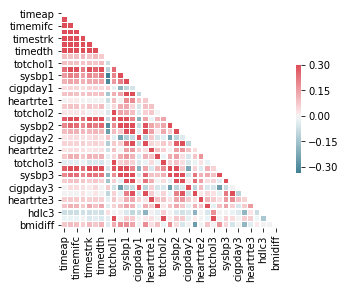

In [409]:
#same with seaborn:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df[not_binary].corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# pearson correlation: testing linear dependency between two noamlly distributed variables, as the following:
# Px,y = COV(x,y)/var(x)*var(y)

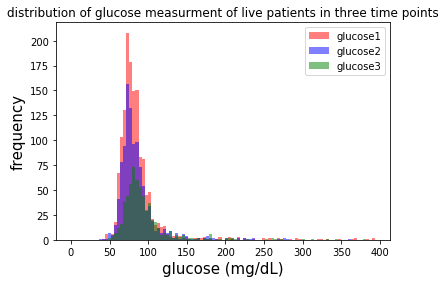

In [410]:
#histogram of glucose in three time points time of healthy people
df_alive = df.groupby(['death']).get_group((1))
glu_cols = [col for col in df.columns if 'glucose' in col]


colors = ['r','b','g']
bins=np.linspace(0, df_alive['glucose1'].max(), 100) # glucose values

for i, col in enumerate(glu_cols):
    plt.hist(df_alive[col], bins, alpha=0.5, label=col,color=colors[i])
plt.legend(loc='upper right')
plt.xlabel("glucose (mg/dL)",fontsize=15)
plt.ylabel("frequency",fontsize=15)
plt.title("distribution of glucose measurment of live patients in three time points")
plt.show()


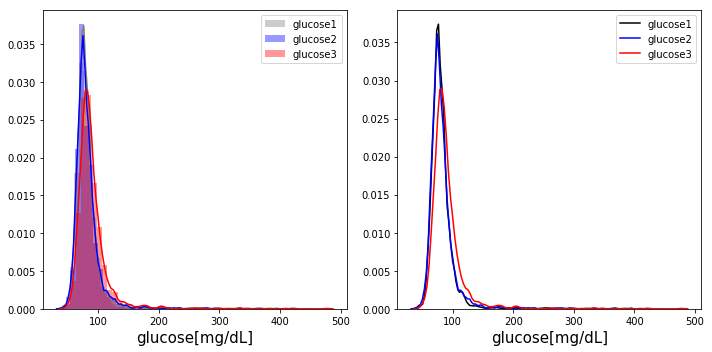

In [448]:
#in seaborn
fig, axs = plt.subplots(1,2,figsize = (10, 5))


sns.distplot(df['glucose1'].dropna(),ax=axs[0], label='glucose1',color='gray')
sns.distplot(df['glucose2'].dropna(),ax=axs[0], label='glucose2',color='blue')
sns.distplot(df['glucose3'].dropna(),ax=axs[0], label='glucose3',color='red')
axs[0].set_xlabel('glucose[mg/dL]', fontsize=15)
axs[0].legend()

sns.kdeplot(df['glucose1'].dropna(),ax=axs[1],color='black')
sns.kdeplot(df['glucose2'].dropna(),ax=axs[1],color='blue')
sns.kdeplot(df['glucose3'].dropna(),ax=axs[1],color='red')
axs[1].set_xlabel('glucose[mg/dL]', fontsize=15)
axs[1].legend()

fig.tight_layout() 

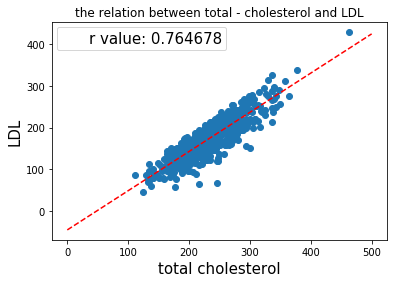

In [411]:
fig, ax = plt.subplots()
ax.scatter(df_alive['totchol3'], df_alive['ldlc3'])
ax.set_title('the relation between total - cholesterol and LDL')
ax.set_xlabel('total cholesterol', fontsize=15)
ax.set_ylabel('LDL', fontsize=15)

#linear regression example
#drop NaNs
reg_df=df_alive[['totchol3','ldlc3']]
reg_df=reg_df.dropna()

y = reg_df['ldlc3']
x = sm.add_constant(reg_df['totchol3']) 

regression_model = sm.OLS(y, x)
regression_results = regression_model.fit()

regression_x = np.array([0, 500]) #depends on your values range
regression_y = regression_results.predict(sm.add_constant(regression_x)) 

r_value=regression_results.rsquared
ax.plot(regression_x, regression_y, '--', color='red')

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
legend = plt.legend([extra],("r value: %f" % r_value,))
text = legend.get_texts()[0]
props = text.get_font_properties().copy()
text.set_fontproperties(props)
text.set_size(15)

Text(0.5, 0, 'Death')

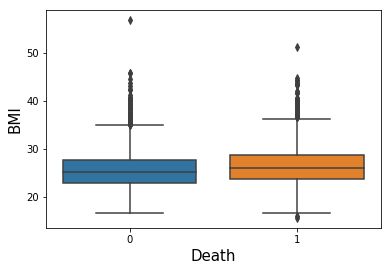

In [497]:
ax= sns.boxplot(x="death", y="bmi1", data=df)
ax.set_ylabel('BMI',fontsize=15)
ax.set_xlabel('Death', fontsize=15)

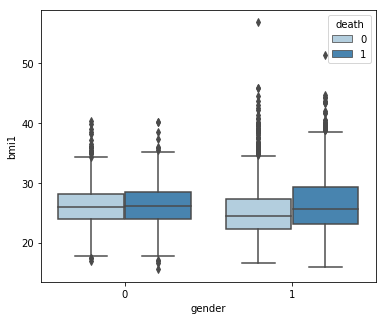

In [515]:
#box plot with seaborn
fig,ax=plt.subplots(figsize=(6,5))
ax=sns.boxplot(x="gender", y="bmi1",hue="death", data=df,palette="Blues")

#for more complicated color modifications:
#https://python-graph-gallery.com/33-control-colors-of-boxplot-seaborn/

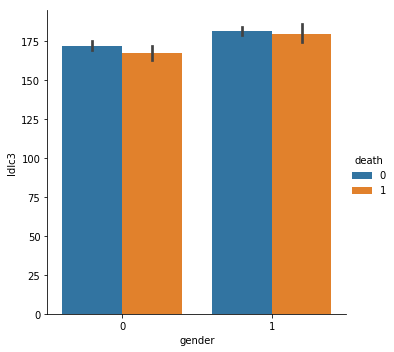

In [456]:
#bar plot with matplotlib
sns.catplot(x="gender", y="ldlc3", hue="death", kind="bar", data=df)

# creating dummy variables

In [477]:
df_cat= pd.read_csv(os.path.join(DIR, 'handouts_fhs.csv'))

In [478]:
df_cat['death']=df_cat['death'].map(lambda x: 'dead' if x=='No' else 'alive')

In [479]:
#creating dummy variables
dummy = pd.get_dummies(df_cat['death'])
df_cat = df_cat.merge(dummy['alive'],left_index=True, right_index=True)

#we need to drop one of the dummy variables to avoid multicolinearity

In [567]:
#lets create a dummy variable for miocardial infraction, angina,cvd
df_cat['mi'] = df_cat['timemi'].map(lambda x: 0 if x==24 else 1)
df_cat['angina']=df_cat['timeap'].map(lambda x: 0 if x==24 else 1)
df_cat['cvd']=df_cat['timecvd'].map(lambda x: 0 if x==24 else 1)

No handles with labels found to put in legend.


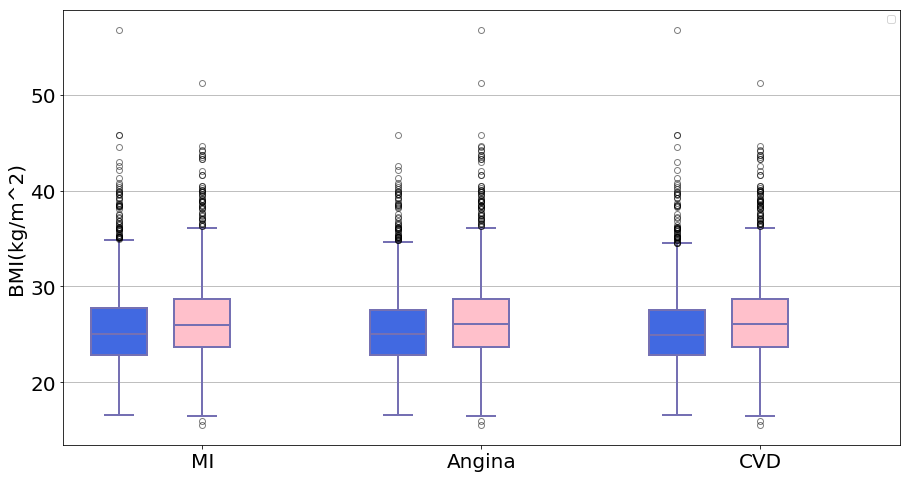

In [614]:
#boxplot by matplotlib for those who did and didnt suffer from angina with heart rate, from MI
# and from another something

offset=[0.3,0.6]

box_colors = ['royalblue','pink']
fig, ax = plt.subplots(figsize = (15, 8))
for i, group in enumerate([0,1]):
    data=[]
    for j, col in enumerate(['mi','angina','cvd']):
        data.append(df_cat.groupby(col).get_group(group)['bmi1'].dropna())
    pos = np.arange(len(data))+offset[i]+3
    bp = ax.boxplot(data, positions= pos,whis = 1.5, widths=0.2,patch_artist=True)

     ## change outline color, fill color and linewidth of the boxes
    for k,box in enumerate(bp['boxes']):
        # change outline color
        box.set(color='#7570b3', linewidth=2)
        # change fill color
        box.set(facecolor = box_colors[i])

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#7570b3', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#7570b3', alpha=0.5)

    
ax.set_xticklabels(['MI','Angina','CVD'], fontsize = 20)
ax.set_ylabel(u'BMI(kg/m^2)', fontsize = 20)
ax.tick_params(labelsize=20)
ax.yaxis.grid(True)
ax.legend()